In [1]:
!pip install -U --user numpy

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires numpy~=1.19.2, but you have numpy 1.20.1 which is incompatible.
tensorflow-cpu 2.4.1 requires numpy~=1.19.2, but you have numpy 1.20.1 which is incompatible.


In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9686 sha256=f0e1a1032ff52a6e43eebd22848e79b28acfc2226b371bf92f04434631b109de
  Stored in directory: c:\users\rnjsx\appdata\local\pip\cache\wheels\bd\a8\c3\3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [3]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import urllib
import wget

MAX_LEN = 384
EPOCHS = 3
VERBOSE = 2
BATCH_SIZE = 16

In [4]:
DATA_OUT_PATH = './data_out/KOR'

In [5]:
def plot_graphs(history, string, string_1, string_2):
    # loss 
    plt.plot(history.history[string])
    plt.plot(history.history[string_1])
    plt.plot(history.history[string_2])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, string_1, string_2])
    plt.show()

In [6]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

In [7]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", lowercase=False)
save_path = "bert-base-multilingual-cased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert-base-multilingual-cased/vocab.txt", lowercase=False)

In [8]:
train_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json"
train_path = keras.utils.get_file("train.json", train_data_url)
eval_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)

In [9]:
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json', out='./bert-base-multilingual-cased/')

100% [..................................................................................] 625 / 625

'./bert-base-multilingual-cased//bert-base-multilingual-cased-config (1).json'

In [10]:
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-config.json', './bert-base-multilingual-cased/config.json')

FileExistsError: [WinError 183] 파일이 이미 있으므로 만들 수 없습니다: './bert-base-multilingual-cased/bert-base-multilingual-cased-config.json' -> './bert-base-multilingual-cased/config.json'

In [11]:
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-tf_model.h5', out='./bert-base-multilingual-cased/')

100% [....................................................................] 1083389348 / 1083389348

'./bert-base-multilingual-cased//bert-base-multilingual-cased-tf_model (1).h5'

In [12]:
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-tf_model.h5', './bert-base-multilingual-cased/tf_model.h5')

FileExistsError: [WinError 183] 파일이 이미 있으므로 만들 수 없습니다: './bert-base-multilingual-cased/bert-base-multilingual-cased-tf_model.h5' -> './bert-base-multilingual-cased/tf_model.h5'

In [13]:
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer.encode(context)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = MAX_LEN - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets


def create_squad_examples(raw_data):
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                answer_text = qa["answers"][0]["text"]
                start_char_idx = qa["answers"][0]["answer_start"]
                squad_eg = SquadExample(
                    question, context, start_char_idx, answer_text
                )
                squad_eg.preprocess()
                squad_examples.append(squad_eg)
    return squad_examples


def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y


In [14]:
with open(train_path) as f:
    raw_train_data = json.load(f)

with open(eval_path) as f:
    raw_eval_data = json.load(f)


train_squad_examples = create_squad_examples(raw_train_data)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

60407 training points created.
5774 evaluation points created.


In [15]:
class TFBERTQuestionAnswering(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBERTQuestionAnswering, self).__init__()
        
        self.encoder = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.start_logit = tf.keras.layers.Dense(num_class, name="start_logit", use_bias=False)
        self.end_logit = tf.keras.layers.Dense(num_class, name="end_logit", use_bias=False)
        self.flatten = tf.keras.layers.Flatten() 
        self.softmax = tf.keras.layers.Activation(tf.keras.activations.softmax)
        
    def call(self, inputs):
        input_ids, token_type_ids, attention_mask = inputs
        embedding = self.encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
        start_logits = self.start_logit(embedding)
        start_logits = self.flatten(start_logits)
        
        end_logits = self.end_logit(embedding)
        end_logits = self.flatten(end_logits)
        
        start_probs = self.softmax(start_logits)
        end_probs = self.softmax(end_logits)
    
        return start_probs, end_probs

In [16]:
korquad_model = TFBERTQuestionAnswering(model_name='./bert-base-multilingual-cased/',dir_path='bert_ckpt', num_class=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

Some layers from the model checkpoint at ./bert-base-multilingual-cased/ were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ./bert-base-multilingual-cased/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [17]:
def normalized_answer(s):    
    def remove_(text):
        ''' 불필요한 기호 제거 '''
        text = re.sub("'", " ", text)
        text = re.sub('"', " ", text)
        text = re.sub('《', " ", text)
        text = re.sub('》', " ", text)
        text = re.sub('<', " ", text)
        text = re.sub('>', " ", text) 
        text = re.sub('〈', " ", text)
        text = re.sub('〉', " ", text)   
        text = re.sub("\(", " ", text)
        text = re.sub("\)", " ", text)
        text = re.sub("‘", " ", text)
        text = re.sub("’", " ", text)      
        return text

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_punc(lower(remove_(s))))

In [18]:
class ExactMatch(keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalized_answer(pred_ans)
            normalized_true_ans = normalized_answer(squad_eg.answer_text)
            if normalized_pred_ans in normalized_true_ans:
                count += 1
        acc = count / len(self.y_eval[0])
        print(f"\nepoch={epoch+1}, exact match score={acc:.2f}")

In [19]:
exact_match_callback = ExactMatch(x_eval, y_eval)

In [20]:
korquad_model.compile(optimizer=optimizer, loss=[loss, loss])

In [21]:
model_name = "tf2_bert_korquad"

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

./data_out/KOR\tf2_bert_korquad -- Folder already exists 



In [ ]:
history = korquad_model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,  # For demonstration, 3 epochs are recommended
    verbose=VERBOSE,
    batch_size=BATCH_SIZE,
    callbacks=[exact_match_callback, cp_callback]
)

In [ ]:
print(history.history)

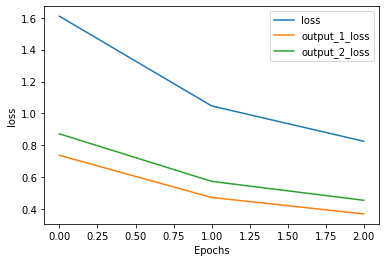

In [24]:
plot_graphs(history, 'loss', 'output_1_loss', 'output_2_loss')

In [25]:
korquad_model.save_weights('weights_KorQuAD.h5')

In [26]:
korquad_model.load_weights('data_out/KOR/tf2_bert_korquad/weights_KorQuAD.h5')

In [27]:
korquad_model.loss

ListWrapper([<tensorflow.python.keras.losses.SparseCategoricalCrossentropy object at 0x0000021032105A60>, <tensorflow.python.keras.losses.SparseCategoricalCrossentropy object at 0x0000021032105A60>])

In [28]:
plot_graphs(korquad_model.history,'loss', 'output_1_loss', 'output_2_loss')

KeyError: 'loss'

### 모델 predict 구현

#### 지문 찾아보기

In [33]:
print(tokenizer.decode(x_eval[0][1]))

1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의 ( 폭력행위등처벌에관한법률위반 ) 으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일 ~ 20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다. 1989년 6월 30일 평양축전에 대표로 파견 된 인물은?


In [56]:
print(x_eval[1][1])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [44]:
tokenized_context= tokenizer.encode("1989년 6월 30일 평양축전에 대표로 파견 된 인물은?")

In [46]:
context_token_to_char = tokenized_context.offsets
print(context_token_to_char)

[(0, 0), (0, 5), (6, 8), (9, 12), (13, 14), (14, 15), (15, 16), (16, 18), (19, 20), (20, 21), (21, 22), (23, 24), (24, 25), (26, 27), (28, 29), (29, 30), (30, 31), (31, 32), (0, 0)]


In [41]:
tokenizer.decode([x_eval[0][1][1]])

'1989년'

In [43]:
for i in x_eval[0][1]:
    print(tokenizer.decode([i]))


1989년
2월
15일
여
##의
##도
농
##민
폭
##력
시
##위를
주
##도
##한
혐
##의
(
폭
##력
##행
##위
##등
##처
##벌
##에
##관
##한
##법
##률
##위
##반
)
으로
지
##명
##수
##배
##되었다
.
1989년
3월
12일
서울
##지
##방
##검
##찰
##청
공
##안
##부는
임
##종
##석
##의
사
##전
##구
##속
##영
##장을
발
##부
##받
##았다
.
같은
해
6월
30일
평
##양
##축
##전에
임
##수
##경
##을
대
##표
##로
파
##견
##하여
국가
##보
##안
##법
##위
##반
혐
##의
##가
추
##가
##되었다
.
경
##찰
##은
12월
18일
~
20일
사
##이
서울
경
##희
##대학교
##에서
임
##종
##석
##이
성
##명
발
##표
##를
추
##진
##하고
있다는
첩
##보를
입
##수
##했고
,
12월
18일
오
##전
7
##시
40
##분
경
가
##스
##총
##과
전
##자
##봉
##으로
무
##장
##한
특
##공
##조
및
대
##공
##과
직
##원
12
##명
등
22
##명의
사
##복
경
##찰
##을
승
##용
##차
8
##대에
나
##누
##어
경
##희
##대학교
##에
투
##입
##했다
.
1989년
12월
18일
오
##전
8
##시
15
##분
경
서울
##청
##량
##리
##경
##찰
##서는
호
##위
학
##생
5
##명
##과
함께
경
##희
##대학교
학
##생
##회
##관
건
##물
계
##단
##을
내
##려
##오는
임
##종
##석
##을
발
##견
,
검
##거
##해
구
##속
##을
집
##행
##했다
.
임
##종
##석
##은
청
##량
##리
##경
##찰
##서
##에서
약
1
##시간
동안
조
##사를
받은
뒤
오
##전
9
##시
50
##분
경
서울
장
##안
##동
##의
서울
##지
##방
##경
##찰
##청
공
##안
##분
##실
##로
인
##계
##

In [36]:
print(x_eval[0][1])

[   101  76485  17520  37912   9565  10459  12092   9027  36553   9929
  28143   9485  31166   9689  12092  11102   9980  10459    113   9929
  28143  25549  19855 101322  60469  68773  10530  20595  11102  33768
  88350  19855  30134    114  29805   9706  16758  15891  76036  13628
    119  76485  15361  46026  48253  12508  42337 118625  99118  40311
   8896  34951  58904   9644  22200  40958  10459   9405  16617  17196
  43962  30858  35963   9323  14646 118965  27303    119  18589   9960
  17253  40636   9926  37114  70122  68767   9644  15891  31720  10622
   9069  37824  11261   9901 118634  13374  93222  30005  34951  33768
  19855  30134   9980  10459  11287   9765  11287  13628    119   8885
  99118  10892  16367  45972    198  41518   9405  10739  48253   8885
  49515  30461  11489   9644  22200  40958  10739   9434  16758   9323
  37824  11513   9765  18623  12453  77324   9749  91693   9645  15891
  38181    117  16367  45972   9580  16617    128  14040  10533  37712
   888

In [59]:
class SquadExample_pred:
    def __init__(self, question, context):#, start_char_idx, answer_text):
        self.question = question
        self.context = context
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        #answer_text = self.answer_text
        #start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())

        # Tokenize context
        tokenized_context = tokenizer.encode(context)
        print("tokenized_context.ids=", tokenized_context.ids)

        # Tokenize question
        tokenized_question = tokenizer.encode(question)
        print("tokenized_question.ids=", tokenized_question.ids)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        
        attention_mask = [1] * len(input_ids)
        

        # Pad and create attention masks.
        # Skip if truncation is needed
        
        padding_length = MAX_LEN - len(input_ids)
        print("padding_length=",padding_length)
        
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return
        
        print("input_ids=", input_ids)
        print("token_type_ids=", token_type_ids)
        print("attention_mask=", attention_mask)

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.context_token_to_char = tokenized_context.offsets
#         print(self.context_token_to_char)
        
    def get_input_target(self):
        dataset_dict = {
            "input_ids": [],
            "token_type_ids": [],
            "attention_mask": [],
        }
        if self.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(self, key))
        for key in dataset_dict:
            dataset_dict[key] = np.array(dataset_dict[key])

        x = [
            dataset_dict["input_ids"],
            dataset_dict["token_type_ids"],
            dataset_dict["attention_mask"],
        ]
        print(x)
        return x

def create_squad_examples_from_arg(question, context):#, start_char_idx, answer_text):
    squad_eg = SquadExample_pred(
        question, context#, start_char_idx, answer_text
    )
    squad_eg.preprocess()
    return squad_eg


def predict_test(model, pred_raw):
    x_pred = pred_raw.get_input_target()
    pred_start, pred_end = model.predict(x_pred)
    
    pred_start_offset_index = np.argmax(pred_start)
    pred_end_offset_index = np.argmax(pred_end)
    pred_start_offset = pred_raw.context_token_to_char[pred_start_offset_index]
    pred_end_offset = pred_raw.context_token_to_char[pred_end_offset_index]
    answer = pred_context[pred_start_offset[0]:pred_end_offset[1]]
    
    normalized_pred_ans = normalized_answer(answer)
    
    return normalized_pred_ans


pred_question = "천문기기를 제작한 공을 인정받아 면천된 년도는?"
pred_context = "장영실은 발명가로서의 훌륭한 재주를 태종이 인정하여 발탁하였다. 세종은 실용주의자로서 장영실의 적성을 중요하게 생각하여 부왕의 뒤를 이어 중용하였다. 세종은 장영실을 1421년(세종 4년) 윤사웅(尹士雄), 최천구(崔天衢) 등과 함께 중국에 보내어 천문기기의 모양을 배워오도록 했다. 귀국 후 장영실 나이 약 34세 때인 1423년(세종 5년)에 천문기기를 제작한 공을 인정받아 면천되었고 다시 대신들의 의논을 거쳐 종5품 상의원(尙衣院) 별좌에 임명되었다.[3] 1424년(세종6) 5월, 임금은 그를 정5품 행사직으로 승진시켰고 갱점지기(更点之器)를 만들라고 명했다. 그래서 나온 것이 첫 물시계였다."

pred_data = create_squad_examples_from_arg(pred_question, pred_context)
pred_answer = predict_test(korquad_model, pred_data)
print(pred_answer)

tokenized_context.ids= [101, 9657, 30858, 31503, 10892, 9323, 16758, 11287, 92413, 10459, 10005, 118901, 11102, 9659, 16323, 11513, 9854, 22200, 10739, 9640, 16605, 13374, 9323, 119335, 12609, 119, 9435, 22200, 10892, 9489, 24974, 37224, 57713, 12424, 9657, 30858, 31503, 10459, 9664, 36456, 9694, 48549, 17594, 9420, 66540, 13374, 9365, 40991, 10459, 9109, 11513, 64749, 9694, 24974, 12609, 119, 9435, 22200, 10892, 9657, 30858, 83380, 77158, 10954, 113, 9435, 22200, 125, 10954, 114, 9627, 12945, 119171, 113, 3476, 3169, 8270, 114, 117, 9764, 38631, 17196, 113, 3548, 3198, 7079, 114, 105464, 19653, 45397, 10530, 9356, 31605, 12965, 9746, 25934, 12310, 46874, 9283, 37114, 10622, 9330, 69592, 28188, 71689, 23622, 119, 8920, 20479, 10003, 9657, 30858, 31503, 8982, 10739, 9539, 11069, 24982, 9137, 12030, 92091, 10954, 113, 9435, 22200, 126, 10954, 114, 9559, 9746, 25934, 12310, 29669, 104865, 11102, 8896, 10622, 9640, 16605, 118965, 16985, 9279, 38631, 49953, 25805, 82642, 25258, 9637, 118743